In [1]:
import math, random
import os 

import gym
from gym import wrappers 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Environment

In [3]:
env_id = "CartPole-v1"
env = gym.make(env_id)
env = wrappers.Monitor(env,'./monitor/cartpole', video_callable=lambda episode_id: episode_id%10==0, force=True)

/home/lisyuan/Lisyuan_Workspace/venv/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Use Cuda

In [4]:
use_cuda = torch.cuda.is_available()
variable = lambda *args, **kwargs: Variable(*args, **kwargs).cuda() if use_cuda else Variable(*args, **kwargs) 

# Replay Buffer

In [5]:
class Replay_Buffer():
    
    def __init__(self):
        
        self.memory = []
        
    def push(self, state, action, reward, next_state, done):
        
        """
        Args:
            state(np.array): the current state
            action: 0 or 1
            reward: 0 or 1
            next_state(np.array): the next state when given action
            done(boolean): finish one episode or not
        """
        
        state = state[np.newaxis, :]
        next_state = next_state[np.newaxis, :]
    
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch):
    
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch))
        
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
   
    def pop(self):
        
        del self.memory[0]

    def __len__(self):
        
        return len(self.memory)

# Epsilon Decay

In [13]:
epsilon_start = 1.0
epsilon_final = 0.01
decay_rate = 50 # decay by episode 

epsilon_decay = lambda episodes: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1 * episodes / decay_rate)

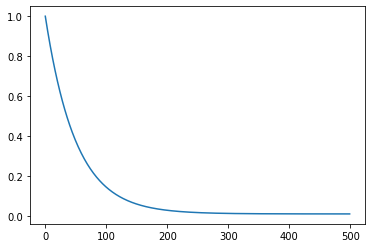

In [7]:
plt.plot([epsilon_decay(i) for i in range(500)])

# Deep Q Network

In [8]:
class DQN(nn.Module):
    
    def __init__(self, num_state, num_action):

        super(DQN, self).__init__()
        self.model = nn.Sequential(nn.Linear(num_state, 64),
                                   nn.ReLU(),
                                   nn.Linear(64, 32),
                                   nn.ReLU(),
                                   nn.Linear(32, num_action))
    def forward(self, x):
        return self.model(x)
    

# Epsilon Greedy Policy 

In [9]:
def policy(state, epsilon):
    
    """
    epsilon greedy policy for exploration and exploitation
    Args:
        state : the current state 
        epsilon: number > epsilon, the action depends on the q-value.
                 otherwise, random action
    returns:
        action: 0 or 1 
    """
    state = variable(torch.from_numpy(state[np.newaxis,:]).float())
    q_value = model(state)
    
    if random.random() > epsilon:
        action = q_value.max(1)[1].item()
    else: 
        action = random.randint(0, 1)

    return action

# Temporal Difference Loss

In [10]:
def update_Qnetwork(batchsize, gamma, optimizer):
    
    """
    caculate the TD-loss and backpropagation    
    """
    state, action, reward, next_state, done = buffer.sample(batchsize)
    
    state = variable(torch.from_numpy(state).float())
    action = variable(torch.tensor(action))
    reward = variable(torch.tensor(reward))
    next_state = variable(torch.from_numpy(next_state).float())
    done = variable(torch.tensor(done).float())


    q_value = model(state)
    next_q_value = model(next_state)
    
    q_value = q_value.gather(1, action.unsqueeze(1)).squeeze(1) # Q(s,a)
    target = reward + gamma * next_q_value.max(1)[0] * (1 - done)

    loss = ((target - q_value)**2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss 

# Plot

In [11]:
save_path = "./figure"

def plot(reward, loss):
    
    clear_output(True)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Rewards vs Episode")
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.plot(reward)
    plt.subplot(1, 2, 2)
    plt.title("loss")
    plt.xlabel('frames')
    plt.ylabel('loss')
    plt.plot(loss)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    plt.savefig(os.path.join(save_path, 'figure.png'))
    plt.show()


# Training

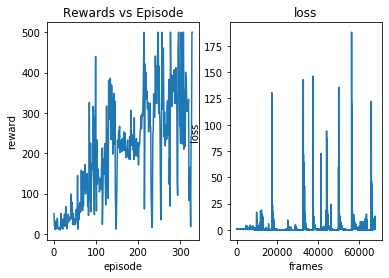

finishing training after 329 episode


In [12]:
episode = 500
buffer_size = 1000
gamma = 0.99
lr = 0.001
step_limit = 500
batchsize = 32

loss_history = []
all_reward = []
episode_reward = 0

# define network and initial buffer 
model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(model.parameters(), lr = lr)
buffer = Replay_Buffer()

if use_cuda:
    model = model.cuda() 

success = 0 
for i in range(episode):
        
    state = env.reset()
    step = 0 
    while True:
       
        env.render()
        
        epsilon = epsilon_decay(episodes = i)
        action = policy(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)
              
        episode_reward += reward
        step += 1
        state = next_state

        if len(buffer) > batchsize:
            loss = update_Qnetwork(batchsize, gamma, optimizer)
            loss_history.append(loss)
            
        if len(buffer) > buffer_size:
            buffer.pop()
        
        if done or episode_reward >= step_limit:
            
            if episode_reward >= step_limit:
                success +=1 
            all_reward.append(episode_reward)           
            episode_reward = 0
            break
 
    if (i+1) % 10 == 0:
        print(f'episode:{i+1}, reward:{all_reward[i]}, finishing after {step} step')

    if success >= 10:
        break
        
plot(all_reward, loss_history)
env.close() 
print(f'finishing training after {i} episode')